In [17]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score





In [18]:
import zipfile
import os


zip_file_path = "/archive (2).zip"


extract_path = "/content/extracted_files"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted successfully to:", extract_path)

print("Extracted files:")
print(os.listdir(extract_path))

Files extracted successfully to: /content/extracted_files
Extracted files:
['diabetic_data.csv', 'description.pdf']


In [27]:
df = pd.read_csv('/content/extracted_files/diabetic_data.csv')
print("Shape:", df.shape)
df.head()

Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [28]:
#Preproceesing
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

df.replace('?', np.nan, inplace=True)

df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

df.dropna(subset=['race', 'gender'], inplace=True)


In [29]:
# Encode 'readmitted' as target
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
label_enc = LabelEncoder()
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    df[col] = label_enc.fit_transform(df[col].astype(str))


In [30]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [31]:
#Train Random forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [32]:
#Evalution  of the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     17665
           1       0.46      0.01      0.01      2234

    accuracy                           0.89     19899
   macro avg       0.67      0.50      0.48     19899
weighted avg       0.84      0.89      0.84     19899

Confusion Matrix:
 [[17651    14]
 [ 2222    12]]
ROC-AUC Score: 0.6379667369508263


In [34]:
X_test_copy = X_test.copy()
X_test_copy['Predicted Probability'] = y_prob
X_test_copy['Risk Flag'] = X_test_copy['Predicted Probability'].apply(lambda x: 'High Risk' if x > 0.5 else 'Low Risk')

X_test_copy.sort_values(by='Predicted Probability', ascending=False).head(10)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,Predicted Probability,Risk Flag
88075,2,0,2,1,1,7,1,43,0,6,...,3,1,0,0,0,0,0,1,0.72,High Risk
100285,2,0,5,3,1,1,2,27,0,17,...,2,1,0,0,0,0,0,1,0.71,High Risk
101629,2,1,2,3,1,7,2,9,1,13,...,3,1,0,0,0,0,0,1,0.65,High Risk
67317,2,0,4,2,1,1,8,37,1,17,...,0,1,0,0,0,0,0,1,0.64,High Risk
78415,2,0,2,1,1,7,2,14,0,8,...,0,1,0,0,0,0,0,1,0.62,High Risk
93922,2,0,5,3,1,1,2,3,0,23,...,2,1,0,0,0,0,0,1,0.61,High Risk
4912,2,0,6,3,1,2,3,41,2,16,...,1,1,0,0,0,0,1,1,0.61,High Risk
49925,0,1,6,2,1,1,3,30,1,10,...,1,1,0,0,0,0,1,1,0.61,High Risk
51251,2,1,6,1,6,7,4,51,1,28,...,2,1,0,0,0,0,0,1,0.60,High Risk
83687,0,0,4,1,6,7,8,73,1,23,...,1,1,0,0,0,0,1,0,0.60,High Risk


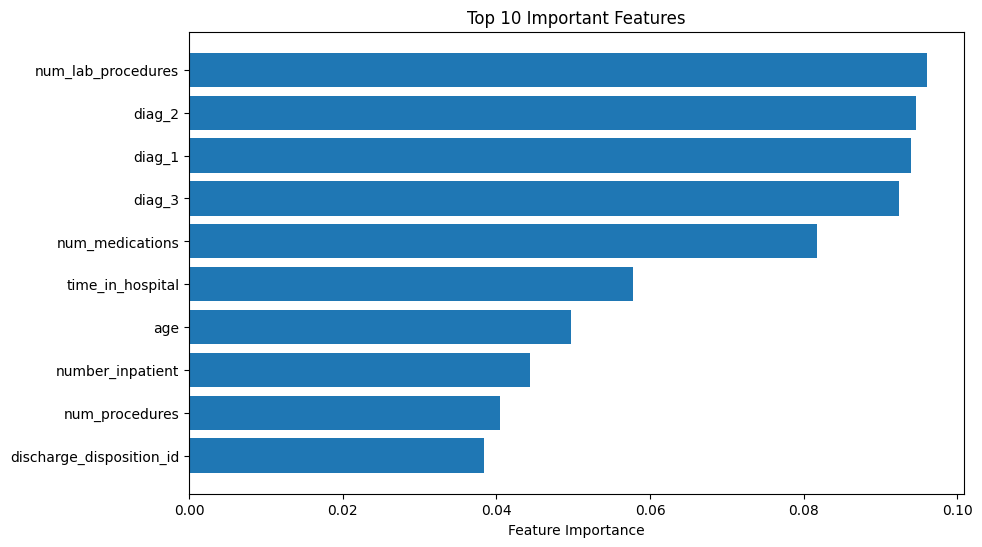

In [35]:
# Plot top 10 important features
importances = model.feature_importances_
features = X.columns
top_idx = np.argsort(importances)[-10:]

plt.figure(figsize=(10,6))
plt.barh(range(10), importances[top_idx], align='center')
plt.yticks(range(10), [features[i] for i in top_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.show()
